# Week 4 - Word Embeddings

This week, we build on last week's topic modeling techniques by taking a text corpus we have developed, specifying an underlying number of dimensions, and training a model with a neural network auto-encoder (one of Google's word2vec  algorithms) that best describes corpus words in their local linguistic contexts, and exploring their locations in the resulting space to learn about the discursive culture that produced them. Documents here are represented as densely indexed locations in dimensions, rather than sparse mixtures of topics (as in LDA topic modeling), so that distances between those documents (and words) are consistently superior, though they require the full vector of dimension loadings (rather than just a few selected topic loadings) to describe. We will explore these spaces to understand complex, semantic relationships between words, index documents with descriptive words, identify the likelihood that a given document would have been produced by a given vector model, and explore how semantic categories can help us understand the cultures that produced them.

For this notebook we will be using the following packages

In [7]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

# Getting our corpora

Instead of downloading our corpora, we have download them in advance; a subset of the [senate press releases](https://github.com/lintool/GrimmerSenatePressReleases) are in `grimmerPressReleases`. We will load them into a DataFrame, using a function from a couple weeks ago `loadTextDirectory`:

In [2]:
kennedyDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases/Kennedy/')
kennedyDF[:5]

,text
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...


This gets us one Senator's data, but with no metadata, we can add a category column with a simple command:

In [3]:
kennedyDF['category'] = 'Kennedy'
kennedyDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also will be wanting to load all the senators so we will need to loop over all the directories

In [4]:
dataDir = '../data/grimmerPressReleases'

senReleasesDF = pandas.DataFrame()

for senatorDir in (file for file in os.scandir(dataDir) if not file.name.startswith('.') and file.is_dir()):
    senDF = lucem_illud.loadTextDirectory(senatorDir.path)
    senDF['category'] = senatorDir.name
    senReleasesDF = senReleasesDF.append(senDF, ignore_index = False)

senReleasesDF[:5]

,text,category
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy


We also want to remove stop words and stem. Tokenizing requires two steps. Word2Vec needs to retain the sentence structure so as to capture a "continuous bag of words (CBOW)" and all of the skip-grams within a word window. The algorithm tries to preserve the distances induced by one of these two local structures. This is very different from clustering and LDA topic modeling which extract unordered words alone. As such, tokenizing is slightly more involved, but we can still use `lucem_illud`.

In [5]:
#Apply our functions, notice each row is a list of lists now
senReleasesDF['tokenized_sents'] = senReleasesDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
senReleasesDF['normalized_sents'] = senReleasesDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

senReleasesDF[:5]

,text,category,tokenized_sents,normalized_sents
01Apr2005Kennedy14.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2005Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."
01Aug2006Kennedy10.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy11.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, wash..."
01Aug2006Kennedy12.txt,FOR IMMEDIATE RELEASE FOR IMMEDIATE ...,Kennedy,"[[FOR, IMMEDIATE, RELEASE, FOR, IMMEDIATE, REL...","[[immediate, release, immediate, release, cont..."


# Word2Vec

We will be using the gensim implementation of [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec).

To load our data, we give all the sentences to the trainer. We just need to add the words as a list of sentences:

In [6]:
senReleasesW2V = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sum())

Inside the word2vec object, the words each have a vector. To access the vector directly, use the square braces (`__getitem__`) method:

In [7]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president']

A 100 dimesional vector:


array([-2.1477232 ,  3.839329  , -0.99012995, -0.33755463,  0.7600124 ,
        1.59997   ,  0.89605683,  3.4121017 , -0.24308   ,  1.2954614 ,
       -0.9542958 , -1.1434901 , -0.4200848 ,  0.53968394, -0.7723568 ,
        0.7204886 , -1.6006107 , -1.9666004 , -0.6312303 ,  0.31710887,
       -0.5276691 ,  0.19513348,  1.3112592 , -0.1212042 , -1.1816422 ,
        0.45158264,  0.74450564, -1.2868177 , -1.2605952 , -1.2620417 ,
        2.6416142 , -0.62808216,  3.2962172 ,  2.8800578 , -0.54629266,
       -2.0662355 , -1.6263342 ,  2.5022385 ,  2.815848  , -0.81786245,
       -1.5224552 , -0.897784  ,  0.32383108,  0.58364415,  1.6652521 ,
        0.68603164,  0.24028964,  0.8454306 ,  1.5515912 , -0.7914124 ,
       -1.47707   ,  1.407559  , -2.0248342 ,  0.49560678, -2.1810896 ,
        1.0898168 , -0.28010052,  2.4184604 , -0.5767022 , -0.6281174 ,
        0.93789595,  1.0347891 ,  2.0354233 , -0.8605121 , -1.7466254 ,
       -1.2601554 , -0.6137958 ,  0.10286617,  0.08200073, -1.00

In [9]:
senReleasesW2V

If you want the full matrix, `syn0` stores all the vectors:

In [8]:
senReleasesW2V.wv.syn0

array([[-0.28485143,  0.03584093,  0.7732712 , ..., -0.7305191 ,
        -1.650449  ,  0.22051173],
       [-0.92609394, -0.7497485 ,  0.51622695, ..., -1.0126107 ,
        -0.04821872,  0.49845818],
       [-0.42815724, -2.216103  ,  2.5821354 , ..., -3.2546039 ,
         0.2689275 ,  1.0047137 ],
       ...,
       [ 0.01586443, -0.03325571,  0.03292124, ..., -0.05126008,
         0.05420509,  0.00940419],
       [ 0.03159003,  0.04017147,  0.0039489 , ..., -0.02381636,
         0.04085605,  0.03957413],
       [ 0.03305597,  0.01430544, -0.00854431, ..., -0.0375199 ,
         0.04133472,  0.02716137]], dtype=float32)

Then, `index2word` lets you translate from the matrix to words

In [10]:
senReleasesW2V.wv.index2word[10]

'american'

Now we can look at a few things that come from the word vectors. The first is to find similar vectors (cosine similarity):

In [11]:
senReleasesW2V.most_similar('president')

[('administration', 0.8008792400360107),
 ('presidents', 0.7314022779464722),
 ('administrations', 0.6651126146316528),
 ('sticklers', 0.6565203666687012),
 ('cheney', 0.6068216562271118),
 ('george', 0.5944485664367676),
 ('responds', 0.5339572429656982),
 ('presidential', 0.5310745239257812),
 ('lamont', 0.5187402963638306),
 ('bolton', 0.5183911919593811)]

In [12]:
senReleasesW2V.most_similar('war')

[('unresisted', 0.6489418148994446),
 ('disobedience', 0.6434783339500427),
 ('afghanistan', 0.6427156329154968),
 ('descending', 0.6286423206329346),
 ('quagmire', 0.618645191192627),
 ('foment', 0.6185049414634705),
 ('wars', 0.6118535995483398),
 ('battle', 0.5894827842712402),
 ('invasion', 0.5853587985038757),
 ('militarily', 0.5797175168991089)]

Or we can get this directly (calculated slightly differently):

In [13]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [14]:
cos_difference(senReleasesW2V, 'war', 'unwinnable')

array([[0.5463091]], dtype=float32)

We can also find which word least matches the others within a word set (cosine similarity):

In [15]:
senReleasesW2V.doesnt_match(['administration', 'administrations', 'presidents', 'president', 'washington'])

'washington'

Find which word best matches the result of a semantic *equation* (here, we seek the words whose vectors best fit the missing entry from the equation: **X + Y - Z = _**.

In [16]:
senReleasesW2V.most_similar(positive=['clinton', 'republican'], negative = ['democrat'])

[('bush', 0.6802624464035034),
 ('veto', 0.6541385650634766),
 ('vetoed', 0.6508108377456665),
 ('signature', 0.6356053352355957),
 ('desk', 0.6326250433921814),
 ('bushs', 0.6286910772323608),
 ('reverse', 0.616399884223938),
 ('signed', 0.6063629388809204),
 ('proposing', 0.600975751876831),
 ('signing', 0.5906930565834045)]

Here we see that **Clinton + Republican - Democrat = Bush**. In other words, in this dataset and period, **Clinton** was to **Democrat** as **Bush** was to **Republican**. Whoah!

 But how do we argue that these are stable distances or associations?

## Establishing Credible or Confidence Intervals

### Boostrapping approach

We propose well-established bootstrapping and subsampling methods to nonparametrically demonstrate the stability and significance of word associations within our embedding model. These allow us to establish conservative confidence intervals to both (a) distances between words in a model and (b) projections of words onto an induced dimension (e.g., man-woman). If we assume that the texts (e.g., newspapers, books) underlying our word embedding model are observations drawn from an independent and identically distributed (i.i.d.) population of cultural observations, then bootstrapping allows us to estimate the variance of word distances and projections by measuring those properties through sampling the empirical distribution of texts with replacement (Efron and Tibshirani 1994; Efron 2003). Operationally, if we wanted to bootstrap a 90% confidence interval of a word-word distance or word-dimension projection, we would sample a corpus the same size as the original corpus, but with replacement, 20 times, estimate word embedding models on each sample. Then we take the 2nd order (2nd smallest) statistic $s_{(2)}$--either distance or projection--as our confidence interval’s lower bound, and 19th order statistic $s_{(19)}$ as its upper bound. The distance between $s_{(2)}$ and $s_{(19)}$ across 20 bootstrap samples span the 5th to the 95th percentiles of the statistic’s variance, bounding the 90th confidence interval. A 95% confidence interval would span $s_{(2)}$ and $s_{(39)}$ in word embedding distances or projections estimated on 40 bootstrap samples of a corpus, tracing the 2.5th to 97.5th percentiles. 

In [17]:
estimatesB=[]
for x in range(20):
    senReleasesW2VB = gensim.models.word2vec.Word2Vec(senReleasesDF['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        estimatesB.append(cos_difference(senReleasesW2VB, 'war', 'unwinnable')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
estimatesB.sort()         
estimatesB

[0.3194977,
 0.32725507,
 0.33980376,
 0.357678,
 0.3609556,
 0.36664072,
 0.36869246,
 0.37803262,
 0.38817635,
 0.45527837,
 0.46828383,
 0.5183778,
 0.52365106,
 0.54797953,
 0.6660341,
 0.707195]

In [18]:
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",estimatesB[1], estimatesB[-2])

The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.32725507 0.6660341


### Subsampling approach

If the corpus is large, then we may take a subsampling approach, which randomly partitions the corpus into non-overlapping samples, then estimates the word-embedding models on these subsets and calculates confidence intervals as a function of the empirical distribution of distance or projection statistics and number of texts in the subsample (Politis and Romano 1997). Subsampling requires the same i.i.d. assumption as the bootrap (Politis and Romano 1992; Politis and Romano 1994). For 90% confidence intervals, we randomly partition the corpus into 20 subcorpora, then calculate $B^k=\sqrt{\tau_k}\left(s^k-\bar{s}\right)$ for each $k$th sample, where $k$ is the number of texts and $s^k$ is the embedding distance or projection for the $k$th sample, and $\bar{s}$ is the average statistic for all samples. The 90% confidence interval spans the 5th to 95th percentile variances, inscribed by $\bar{s}-\frac{B_{(19)}^k}{\sqrt{\tau}}$ and $\bar{s}-\frac{B_{(2)}^k}{\sqrt{\tau}}$, where $\tau$ the number of texts in the total corpus and $s$ is the average statistic across all subsamples. As with bootrapping, a 95% confidence interval would require 40 subsamples; a 99% confidence would require 200 (.5th to 99.5th percentiles).

In [19]:
senReleasesDF[sample_indices == i]

NameError: name 'sample_indices' is not defined

In [20]:
n_samples = 10
sample_indices = np.random.randint(0,n_samples,(len(senReleasesDF),))

s_k =np.array([])
tau_k=np.array([])

for i in range(n_samples):
    sample_w2v = gensim.models.word2vec.Word2Vec(senReleasesDF[sample_indices == i]['normalized_sents'].sum())
    try:
        #Need to use words present in most samples
        s_k = np.append(s_k, cos_difference(sample_w2v, 'war', 'responsibility')[0,0])
    except KeyError:
        pass
    else:
        tau_k = np.append(tau_k, len(senReleasesDF[sample_indices == i]))

print(s_k)
print(tau_k)

tau = tau_k.sum()
s = s_k.mean()
B_k = np.sqrt(tau_k) * s_k-s_k.mean()

[0.95500129 0.99711931 0.98936945 0.96108758 0.96701264 0.97226471
 0.98176384 0.97908151 0.94906205 0.99334228]
[375. 370. 386. 392. 369. 380. 396. 416. 404. 416.]


In [21]:
print("The 90% confidence interval for the cosine distance between war and responsibility is:\n",s-B_k[-2]/np.sqrt(tau), s-B_k[1]/np.sqrt(tau))

The 90% confidence interval for the cosine distance between war and responsibility is:
 0.6848046095214868 0.6831391421298227


We can also save the vectors for later use:

In [22]:
senReleasesW2V.save("senpressreleasesWORD2Vec.mm")
#Load with senReleasesW2V = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

## Visualize

We can also use dimension reduction to visulize the vectors. We will start by selecting a subset we want to plot. Let's look at the top words from the set:

In [23]:
numWords = 150
targetWords = senReleasesW2V.wv.index2word[:numWords]

We can then extract their vectors and create our own smaller matrix that preserved the distances from the original:

In [24]:
wordsSubMatrix = []
for word in targetWords:
    wordsSubMatrix.append(senReleasesW2V[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.28485143,  0.03584093,  0.7732712 , ..., -0.7305191 ,
        -1.650449  ,  0.22051173],
       [-0.92609394, -0.7497485 ,  0.51622695, ..., -1.0126107 ,
        -0.04821872,  0.49845818],
       [-0.42815724, -2.216103  ,  2.5821354 , ..., -3.2546039 ,
         0.2689275 ,  1.0047137 ],
       ...,
       [ 1.4811281 , -0.65650403, -1.158478  , ..., -0.62745625,
         0.14628555,  0.30349106],
       [ 0.504006  ,  0.6817335 , -0.5155293 , ...,  0.00517544,
        -1.1219692 ,  0.1416335 ],
       [ 0.5592662 , -0.5841926 , -0.41784108, ...,  0.50106764,
        -0.6899424 , -1.2611321 ]], dtype=float32)

Then we can use PCA to reduce the dimesions (e.g., to 50), and [T-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) to project them down to the two we will visualize. We note that this is nondeterministic process, and so you can repeat and achieve alternative projectsions/visualizations of the words:

In [25]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

We now can plot the points

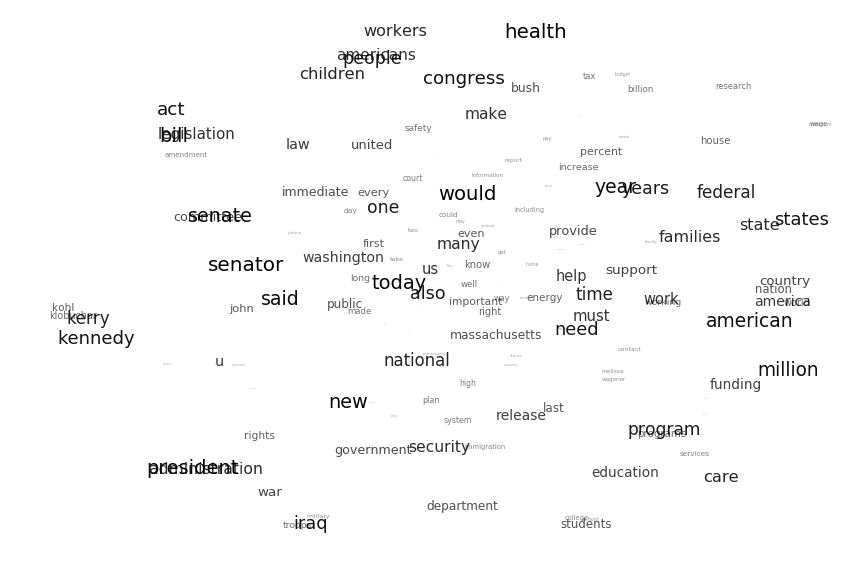

In [26]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

My visualization above puts ``iraq`` next to ``time`` and ``bill`` near ``help``. <img src='../data/examplewordcloud.svg'>

What if a new senator come along with whose names starts with K? Could we analyse their releases too without rerunning the entire embedding? Lets try with Cardin in `../data/grimmerPressReleases_extra/Cardin`. First we need to load and proccess the releases:

In [27]:
cardinDF = lucem_illud.loadTextDirectory('../data/grimmerPressReleases_extra/Cardin')
cardinDF['category'] = 'Cardin'

cardinDF['tokenized_sents'] = cardinDF['text'].apply(lambda x: 
                                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
cardinDF['normalized_sents'] = cardinDF['tokenized_sents'].apply(lambda x: 
                                                                           [lucem_illud.normalizeTokens(s, 
                                                                                           stopwordLst = lucem_illud.stop_words_basic, 
                                                                                           stemmer = None) 
                                                                            for s in x])

cardinDF[:10]

,text,category,tokenized_sents,normalized_sents
01Aug2007Cardin156.txt,...,Cardin,"[[CARDIN, MIKULSKI, PRAISES, PASSAGE, OF, STRO...","[[cardin, mikulski, praises, passage, strong, ..."
01Feb2007Cardin297.txt,...,Cardin,"[[CARDIN, VOTES, TO, INCREASE, MINIMUM, WAGE, ...","[[cardin, votes, increase, minimum, wage, pay,..."
01Feb2007Cardin298.txt,...,Cardin,"[[S, 453, SEN, CARDIN, CO, SPONSORS, BILL, TO,...","[[sen, cardin, co, sponsors, bill, protect, vo..."
01Feb2007Cardin299.txt,...,Cardin,"[[S, 450, CARDIN, INTRODUCES, BILL, TO, ELIMIN...","[[cardin, introduces, bill, eliminate, arbitra..."
01Jun2007Cardin199.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 7, 3, MILLION, F...","[[cardin, mikulski, announce, million, hagerst..."
01Jun2007Cardin200.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 4, 6, MILLION, F...","[[cardin, mikulski, announce, million, salisbu..."
01Mar2007Cardin279.txt,...,Cardin,"[[SEN, CARDIN, FIGHTS, TO, IMPROVE, SECURITY, ...","[[sen, cardin, fights, improve, security, amer..."
01Mar2007Cardin280.txt,...,Cardin,"[[CARDIN, MIKULSKI, ANNOUNCE, 35, 000, FOR, WE...","[[cardin, mikulski, announce, western, marylan..."
01May2007Cardin228.txt,...,Cardin,"[[STATEMENT, BY, U, S, SENATOR, BENJAMIN, L, C...","[[statement, u, senator, benjamin, l, cardin, ..."
01May2007Cardin229.txt,...,Cardin,"[[CARDIN, TELLS, THE, AG, COMMITTEE, THAT, THE...","[[cardin, tells, ag, committee, farm, bill, co..."


We can now merge Cardin's releases with the rest. This can update all the weights in *w2v* model, so be careful.

In [31]:
#This is using a newer API so we have to tell it a little bit more for it to work right
senReleasesW2V.build_vocab(cardinDF['normalized_sents'].sum(), update=True)
senReleasesW2V.train(cardinDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=senReleasesW2V.iter)
senReleasesW2V.save("senpressreleasesWORD2Vec_new.mm")

As the model is updated by this, we need to load our old copy to do a comparison.

In [32]:
senReleasesW2V_old = gensim.models.word2vec.Word2Vec.load('senpressreleasesWORD2Vec.mm')

In [33]:
print("A {} dimesional vector:".format(senReleasesW2V['president'].shape[0]))
senReleasesW2V['president'][:10]

A 100 dimesional vector:


array([-2.3696206,  3.400688 , -1.0426551, -0.3482925,  0.6652173,
        1.5923328,  1.058138 ,  3.3057017, -0.3328402,  1.3559421],
      dtype=float32)

In [34]:
print("A {} dimesional vector:".format(senReleasesW2V_old['president'].shape[0]))
senReleasesW2V_old['president'][:10]

A 100 dimesional vector:


array([-2.1477232 ,  3.839329  , -0.99012995, -0.33755463,  0.7600124 ,
        1.59997   ,  0.89605683,  3.4121017 , -0.24308   ,  1.2954614 ],
      dtype=float32)

In [35]:
(senReleasesW2V_old['president'] - senReleasesW2V['president'])[:10]

array([ 0.22189736,  0.43864107,  0.05252516,  0.01073787,  0.09479511,
        0.00763714, -0.16208118,  0.10640001,  0.0897602 , -0.06048071],
      dtype=float32)

As you can see the vector for 'president' has changed a little bit and the word cloud should also be a bit different too

In [36]:
pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_data = pcaWords.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(reducedPCA_data)

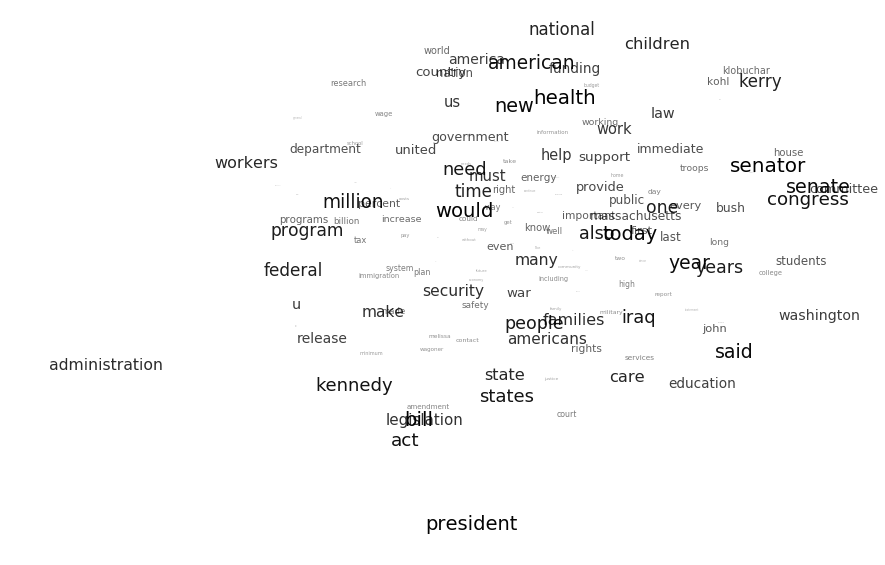

In [37]:
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWords[:, 0], tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(targetWords):
    ax.annotate(word, 
                (tsneWords[:, 0][i],tsneWords[:, 1][i]), 
                size =  20 * (numWords - i) / numWords, 
                alpha = .8 * (numWords - i) / numWords + .2)
plt.xticks(())
plt.yticks(())
plt.show()

Another thing to consider in training is how we know that our parameters for the model are correct. We can do this by looking at the training loss of the model. Let's tart by training a new model, but this time we will expose most of the options and train it one epoch at a time. Look [here](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) for more detail: 

In [38]:
senReleasesW2V_loss = gensim.models.word2vec.Word2Vec(size = 100, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
senReleasesW2V_loss.build_vocab(senReleasesDF['normalized_sents'].sum())
senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
#Using a list so we can capture every epoch
losses = [senReleasesW2V_loss.running_training_loss]
losses[0]

1977497.125

Now we have the training loss and can optimize training to minimize it.

In [39]:
for i in range(19):
    senReleasesW2V_loss.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1,
                             )
    losses.append(senReleasesW2V_loss.running_training_loss)
    print("Done epoch {}".format(i + 2), end = '\r')

Lets plot the loss vs epoch

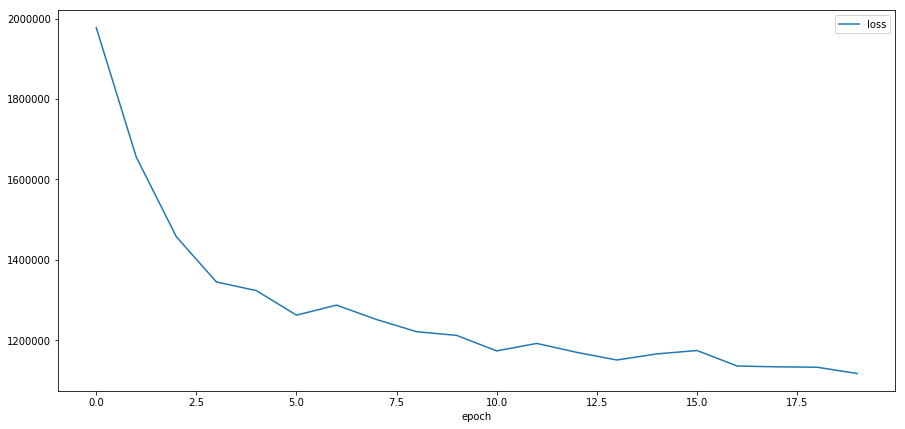

In [40]:
lossesDF = pandas.DataFrame({'loss' : losses, 'epoch' : range(len(losses))})
lossesDF.plot(y = 'loss', x = 'epoch', logy=False, figsize=(15, 7))
plt.show()

You should see that the loss is almost monotonic, but that the rate decreases as epoch increases. Since we are testing on our training data monotonicity is a common result and we must try to avoid over fitting. A simple way to do this is to stop training when there is significant change in the rate of decrease. In this run, that looks to be approximately 8 or 9. If we were to do another analysis, we might use an `iter=9` instead of the default 5.

Even more culturally interesting is how many dimensions are required to achieve an optimal embedding. The use of words in complex ways and contradictory contexts will require more dimensions to represent them with integrity. For example, if one word, $w_a$, is "nearby" $w_b$, but $w_b$ is not near the other words beside $w_a$, then a new dimension will be required for the two words to be uniquely together. 

In [41]:
losses_dims=[]

for d in [50,100,150,200,250,300,350,400,450,500, 550, 600, 650, 700, 750]:
    senReleasesW2V_loss_dims = gensim.models.word2vec.Word2Vec(size = d, #dimensions
                                                      alpha=0.025,
                                                      window=5,
                                                      min_count=5,
                                                      hs=0,  #hierarchical softmax toggle
                                                      compute_loss = True,
                                                     )
    senReleasesW2V_loss_dims.build_vocab(senReleasesDF['normalized_sents'].sum())
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=7, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    senReleasesW2V_loss_dims.train(senReleasesDF['normalized_sents'].sum(), 
                     total_examples=senReleasesW2V.corpus_count, 
                     epochs=1, #This the running_training_loss is a total so we have to do 1 epoch at a time
                    )
    
    losses_dims.append(senReleasesW2V_loss_dims.running_training_loss/(10+d*10))

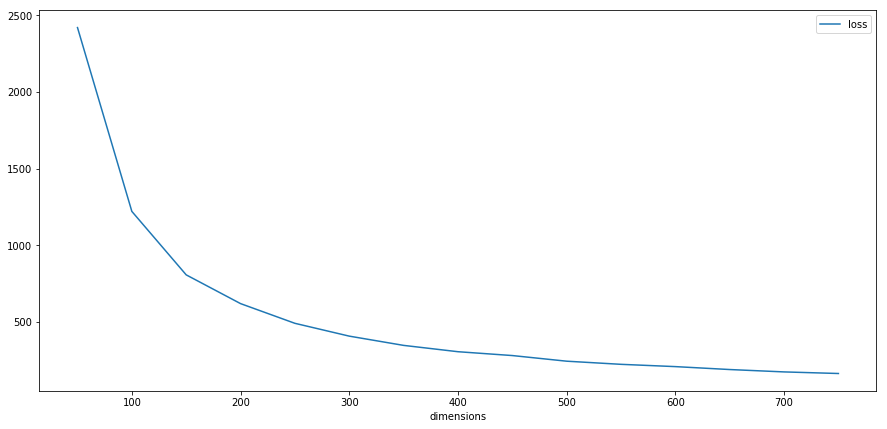

In [42]:
losses_dimsDF = pandas.DataFrame({'loss' : losses_dims, 'dimensions' : [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750]})
losses_dimsDF.plot(y = 'loss', x = 'dimensions', logy=False, figsize=(15, 7))
plt.show()

This is a work in progress for Gensim, but its clear that most of the word distance variation is captured by 300 dimensions.

# Chinese examples

In [ ]:
model=gensim.models.Word2Vec.load('../data/1992embeddings_hs_new3.sg')

## analogy

King+man-Queen? A few examples based on a corpus of Chinese news. 

First, location analogy: **province -> capital**

In [ ]:
mm = model.most_similar(positive=[u'长沙',u'陕西'], negative=[u'湖南']) # Changsha + Shaanxi - Hunan
for m in mm:
    print(m[0],m[1])
    print("Xi'an")
    break

In [ ]:
mm = model.most_similar(positive=[u'广州',u'湖北'], negative=[u'广东']) # Guangzhou + Hubei - Guangdong
for m in mm:
    print(m[0],m[1])
    print("Wuhan")
    break

Second, location analogy: **country -> capital**

In [ ]:
mm = model.most_similar(positive=[u'东京',u'美国'], negative=[u'日本']) # Tokyo + US - Japan
for m in mm:
    print(m[0],m[1])
    print("(Washington DC)")
    break

## similar words

In [ ]:
word = u'社会主义'  #socialism
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

In [ ]:
word = u'玉米'  # corn
ss = model.similar_by_word(word,topn=10)
print("the most similar words to " + word + " is: ")
for s in ss:
    print(s[0])
print("")

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that build a word2vec model with your corpus. Interrogate word relationships in the resulting space, including estimating 90% confidence intervals for specific word cosine distances of interest. Plot a subset of your words. What do these word relationships reveal about the *social* and *cultural game* underlying your corpus? What was surprising--what violated your prior understanding of the corpus? What was expected--what confirmed your knowledge about this domain?

In [5]:
### Initialize ###
import re

# Read in the data
file_path = os.path.abspath('..') + '/data/music'
file_lst = os.listdir(file_path)[1:] # ignore the hidden file generated by the system

# Write the data into dictionary
d = {'file_name':[], 'text':[], 'music_type':[]}
for filename in file_lst:
    text = ''
    music_type = ''
    with open(file_path+'/'+filename) as f:
        for line in f:
            text += line.strip('\n')
    filename_split = filename.split() # get rid of redundant information in file names to get the music type
    for i in range(len(filename_split)):
        filename_split[i] = re.sub('.txt', '', filename_split[i])
        if filename_split[i] != '–':
            if filename_split[i] != '-':
                if i != 0:
                    music_type = music_type + ' ' + filename_split[i]
                else:
                    music_type += filename_split[i]
            else:
                break
        else:
            break
    d['text'].append(text)
    d['file_name'].append(filename)
    d['music_type'].append(music_type)

# Convert dictionary into Pandas DataFrame
df = pandas.DataFrame(d)
df['tokenized_sents'] = df['text'].apply(lambda x: [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
df['normalized_sents'] = df['tokenized_sents'].apply(lambda x: [lucem_illud.normalizeTokens(s, stopwordLst = lucem_illud.stop_words_basic, stemmer = None) for s in x])


In [6]:
### word2vec ###
musicW2V = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sum())
print('The most similar words to "blues" are: ')
print(musicW2V.most_similar('blues'))
print('The most similar words to "rock" are: ')
print(musicW2V.most_similar('rock'))


The most similar words to "blues" are: 
[('piedmont', 0.8054066896438599), ('jazz', 0.7846641540527344), ('moody', 0.7846471071243286), ('swing', 0.7844865322113037), ('pappo', 0.7702431678771973), ('jelly', 0.7491304874420166), ('boogie', 0.7355663776397705), ('harum', 0.734762966632843), ('procol', 0.7307246327400208), ('bluegrass', 0.7289830446243286)]
The most similar words to "rock" are: 
[('jelly', 0.8234177827835083), ('rockabilly', 0.77293860912323), ('british', 0.7718219757080078), ('ska', 0.7545918822288513), ('pop', 0.7350552082061768), ('bluegrass', 0.7231903076171875), ('garage', 0.7028215527534485), ('surf', 0.7027810215950012), ('psychedelic', 0.7008488178253174), ('psychedelia', 0.6973282098770142)]


<span style="color:blue"> In the above cell, I interrogate the relationship between 'blues' and other words, and the relationship between 'rock' and other words. For the word 'blues', its most similar words are 'piedmont', 'jazz', 'moody', 'swing', 'pappo', 'jelly', 'boogie', 'harum', 'procol', and 'bluegrass'. It means they frequently appear close to the word 'blues'. Especially the 'jazz', 'moody', 'swing', and 'harum', they are very related to Blues Music in the real life. And the words most similar to 'rock' are 'jelly', 'rockabilly', 'British', 'ska', 'pop', 'bluegrass', 'garage', 'surf', and 'psychedelic'. They are music genras or places highly related to Rock Music. The results make sense.

In [90]:
musicW2V.doesnt_match(['blues', 'rock', 'pop', 'funk', 'house', 'country'])


'house'

<span style="color:blue"> With the code above, I check which word is most dissimilar to the other words. I gives 6 words of music genras, and it tells me that the 'house' is the one doesn't match with others. There might be 2 reasons. One is that House Music is really different from the other music genres. The other explanation is that the machine does not recognize the word 'house' as a music genra, and it recognizes it as a building instead.</span>

In [9]:
musicW2V.most_similar(positive=['blues', 'drum'], negative=['piano'])


[('soul', 0.7651386260986328),
 ('funk', 0.7500089406967163),
 ('reggae', 0.7291688919067383),
 ('swing', 0.7105961441993713),
 ('breakstep', 0.7061077356338501),
 ('garage', 0.7008155584335327),
 ('electro', 0.6956042051315308),
 ('jungle', 0.6944583654403687),
 ('house', 0.6882315874099731),
 ('trap', 0.6881532073020935)]

<span style="color:blue"> The top 3 results are: blues to piano as soul to drum; blues to piano as funk to drum; blues to piano as reggae to drum. The machine amazingly pairs the related genras and instruments.</span>

In [11]:
musicW2V.most_similar(positive=['rock', 'violence'], negative=['blues'])


[('politics', 0.7386474609375),
 ('drugs', 0.7296756505966187),
 ('positive', 0.7276981472969055),
 ('christian', 0.7117506265640259),
 ('drug', 0.7116459608078003),
 ('imagery', 0.7087405920028687),
 ('satanism', 0.6955381035804749),
 ('violent', 0.6954022645950317),
 ('taqwacore', 0.6918598413467407),
 ('viking', 0.6894435882568359)]

<span style="color:blue"> The top 3 results are: rock to blues is like politics to violence; rock to blues is like drugs to violence; rock to blues is like positive to violence. This gives confusing results. The relationships are sometimes positive and sometimes negative. Maybe because the relationship between rock and blues is already very complicated. They may share some similarities (like both of them are moody), but still have some dissimilarities (like their styles).</span>

In [94]:
### Confidence intervals ###

# Using the cos_difference function built above, directly use bootstrap to construct the 90%
# confidence intervals
music_estimatesB=[]
for x in range(20):
    musicW2VB = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sample(frac=1.0, replace=True).sum())
    try:
        music_estimatesB.append(cos_difference(musicW2VB, 'blues', 'orchestra')[0,0])
    except KeyError:
        #Missing one of the words from the vocab
        pass
                                                      
music_estimatesB.sort()         
music_estimatesB
print("The 90% confidence interval for the cosine distance between war and unwinnable is:\n",music_estimatesB[1], music_estimatesB[-2])


The 90% confidence interval for the cosine distance between war and unwinnable is:
 0.12666166 0.43234038


<span style="color:blue"> With bootstrap, the constructed 90% confidence interval is approximately (0.127, 0.432).</span>

In [12]:
### Visualization ###

# Get the matrix
music_numWords = 200
top_music_words = musicW2V.wv.index2word[:music_numWords]
musicSubMatrix = []
for word in top_music_words:
    musicSubMatrix.append(musicW2V[word])
musicSubMatrix = np.array(musicSubMatrix)

# PCA
music_pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(musicSubMatrix)
music_reducedPCA_data = music_pcaWords.transform(musicSubMatrix)
#T-SNE is theoretically and empirically better, since words with PCA are grouped together, 
#very hard to see clearly
music_tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(music_reducedPCA_data)


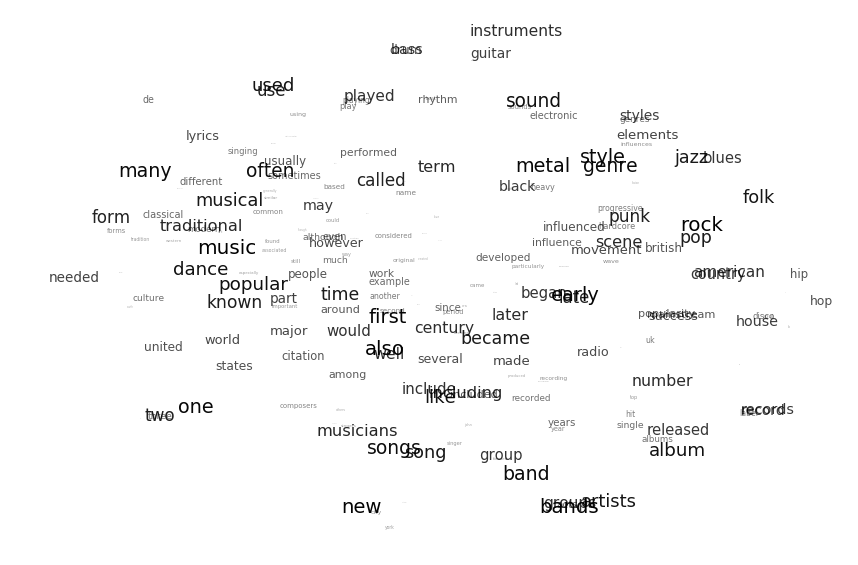

In [96]:
# Plot
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(music_tsneWords[:, 0], music_tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(top_music_words):
    ax.annotate(word, 
                (music_tsneWords[:, 0][i],music_tsneWords[:, 1][i]), 
                size =  20 * (music_numWords - i) / music_numWords, 
                alpha = .8 * (music_numWords - i) / music_numWords + .2)
plt.xticks(())
plt.yticks(())
plt.title('Figure: Visualization of Key Words in Corpus')
plt.show()

<span style="color:blue"> I plot a 200-word subset of my words. And I think the social and cultural games underlying this corpus are that the music genras would be mentioned more than specific music elements, that genras sharing some similarities would appear closely to each other, and that music genras themselves might be close themselves but far from others things such as words to describe their styles. My goal is to classify music genras into several categories, with their descriptions on Wikipedia. </span>

<span style="color:blue"> The plot above gives their relationships, which shows some very interesting patterns. For example, punk, rock, and pop are relatively close to each other. Jazz and blues are very close to each other. Electronic music is relatively far from the hip hop music. And dance is very far from the main music genres, appearing with some adjectives, showing that 'dance' is something that is used to describe some music genres. The machine correctly differentiate music and the other items.

<span style="color:blue"> The surprising parts are that house music is very far from electronic music, and that guitar is not put next to folk music. Maybe it's because they are not co-locations, or the algorithm is doing too well to seperate music instruments from music genras.</span>

# Doc2Vec

Instead of just looking at just how words embed within in the space, we can look at how the different documents relate to each other within the space. First lets load our data--abstracts of most U.S. physics papers from the 1950s.

In [28]:
apsDF = pandas.read_csv('../data/APSabstracts1950s.csv', index_col = 0)
apsDF[:10]

,copyrightYear,doi,abstract
0,1950,10.1103/RevModPhys.22.221,A summarizing account is given of the research...
1,1951,10.1103/RevModPhys.23.147,New tables of coulomb functions are presented ...
2,1951,10.1103/RevModPhys.23.185,Ionization by electron impact in diatomic gase...
3,1951,10.1103/RevModPhys.23.203,It is shown that the conductivity in the ohmic...
4,1951,10.1103/RevModPhys.23.21,The factorization method is an operational pro...
5,1951,10.1103/RevModPhys.23.311,A brief account is given of Dyson's proof of t...
6,1951,10.1103/RevModPhys.23.315,A systematics is given of all transitions for ...
7,1951,10.1103/RevModPhys.23.322,A systematics of the -transitions of even A nu...
8,1951,10.1103/RevModPhys.23.328,The available experiments on the absorption sp...
9,1952,10.1103/RevModPhys.24.108,The classical theory of the dynamics of viscou...


We will load these as documents into Word2Vec, but first we need to normalize and pick some tags

In [29]:
keywords = ['photomagnetoelectric', 'quantum', 'boltzmann', 'proton', 'positron', 'feynman', 'classical', 'relativity']

In [30]:
apsDF['tokenized_words'] = apsDF['abstract'].apply(lambda x: nltk.word_tokenize(x))
apsDF['normalized_words'] = apsDF['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [53]:
taggedDocs = []
for index, row in apsDF.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in keywords if s in row['normalized_words']]
    docKeywords.append(row['copyrightYear'])
    docKeywords.append(row['doi']) #This lets us extract individual documnets since doi's are unique
    taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
apsDF['TaggedAbstracts'] = taggedDocs

In [56]:
taggedDocs[0]

LabeledSentence(words=['summarizing', 'account', 'given', 'research', 'barium', 'titanate', 'progress', 'laboratory', 'insulation', 'research', 'since', 'investigations', 'led', 'understanding', 'mechanism', 'ferroelectricity', 'titanates', 'discoveries', 'piezoelectric', 'effect', 'ceramics', 'domain', 'structure', 'single', 'crystals', 'high', 'dielectric', 'constant', 'field', 'strength', 'temperature', 'sensitivity', 'barium', 'titanate', 'dielectrics', 'make', 'useful', 'numerous', 'technical', 'applications'], tags=[1950, '10.1103/RevModPhys.22.221'])

Now we can train a Doc2Vec model:

In [57]:
apsD2V = gensim.models.doc2vec.Doc2Vec(apsDF['TaggedAbstracts'], size = 100) #Limiting to 100 dimensions

We can get vectors for the tags/documents, just as we did with words. Documents are actually the centroids (high dimensional average points) of their words. 

In [58]:
apsD2V.docvecs[1952]

array([ 1.8594257 , -0.7739975 ,  0.37680265,  0.37826052,  0.32363224,
        1.3400569 , -0.6295213 ,  0.08966756,  0.14650568,  0.12909718,
        0.8125648 , -0.87564594,  0.7757604 , -0.91851246, -1.2932882 ,
       -1.5216585 ,  1.1107786 ,  1.4442749 , -1.5358977 ,  1.2299138 ,
       -0.02013158,  0.01649299, -1.8237692 , -0.63862216,  0.00783723,
       -0.01208309,  0.37796906, -0.7878635 , -1.0897795 ,  0.8598584 ,
        1.2703143 , -0.10664146, -0.5092184 , -0.33623463,  0.243267  ,
        0.9582447 ,  0.213912  , -1.2864062 ,  0.30482388, -0.3091721 ,
       -1.388112  ,  0.3843029 ,  0.07202732,  0.88460547,  0.21312237,
       -0.64423484, -0.6138051 , -0.42688993,  0.1550391 ,  0.6684369 ,
       -0.6765047 ,  1.0636617 ,  0.3137793 , -0.7562303 ,  0.19292597,
        0.8358665 , -1.2889475 ,  0.21591331, -2.328253  , -0.6088732 ,
       -0.36645675, -0.6252652 ,  1.5429512 , -1.2204201 , -0.48497775,
       -0.69309855, -1.3925432 ,  1.2097055 ,  0.872849  , -0.19

The words can still be accessed in the same way:

In [59]:
apsD2V['atom']

array([ 0.5412525 ,  0.07662551, -0.90148103, -0.11499042,  0.47334263,
        1.4129065 , -0.9199912 ,  0.13484876, -0.15336329,  0.52730757,
        0.31185246, -1.194402  ,  0.880663  , -0.5589024 ,  0.758786  ,
       -0.20054992,  0.71679634,  0.41739288, -1.1930525 ,  0.00833476,
       -0.05540655, -0.10165493, -0.7823759 ,  0.12909845, -0.3303593 ,
        0.34653577,  0.8523008 , -0.900999  ,  0.3286315 ,  0.49712098,
        0.34624428,  0.12112688, -0.08321559,  0.5727198 ,  0.57474035,
        1.1703894 ,  1.2023859 , -0.36571297,  0.5336934 , -0.10117098,
       -0.44765174,  0.29839772, -0.05704807,  0.4030187 ,  0.0114693 ,
        0.37316298,  0.35670766,  0.08927923, -0.521356  ,  1.116705  ,
       -0.3773776 ,  0.04264256, -0.74399173, -0.12861302,  0.15902637,
        0.6563579 , -0.20302346, -0.07218857, -0.3250126 , -0.29176405,
        0.40137556,  0.4125996 , -0.143032  , -0.12430907,  0.2542821 ,
       -0.21388687, -0.08950678,  0.17993428, -0.5912501 , -0.31

We can still use the ``most_similar`` command to perform simple semantic equations:

In [62]:
apsD2V.most_similar(positive = ['atom','electrons'], negative = ['electron'], topn = 1)

[('predominates', 0.8078998923301697)]

This is interesting. **Electron** is to **electrons** as **atom** is to **atoms**. Another way to understand this, developed below is: **electrons - electron** induces a singular to plural dimension, so when we subtract **electron** from **atom** and add **electrons**, we get **atoms**! 

In [60]:
apsD2V.most_similar(positive = ['einstein','law'], negative = ['equation'], topn = 1)

[('sensitively', 0.9479737877845764)]

In other words **Einstein** minus **equation** plus **law** equals **Meissner**--Walthur Meissner studied mechanical engineering and physics ... and was more likely to produce a "law" than a "equation", like the Meissner effect, the damping of the magnetic field in superconductors. If we built our word-embedding with a bigger corpus like the entire arXiv, a massive repository of physics preprints, we would see many more such relationships like **gravity - Newton + Einstein = relativity**.

We can also compute all of these *by hand*--explicitly wth vector algebra: 

In [63]:
sklearn.metrics.pairwise.cosine_similarity(apsD2V['electron'].reshape(1,-1), apsD2V['positron'].reshape(1,-1))
#We reorient the vectors with .reshape(1, -1) so that they can be computed without a warning in sklearn

array([[0.5917598]], dtype=float32)

In the doc2vec model, the documents have vectors just as the words do, so that we can compare documents with each other and also with words (similar to how a search engine locates a webpage with a query). First, we will calculate the distance between a word and documents in the dataset:

In [64]:
apsD2V.docvecs.most_similar([ apsD2V['electron'] ], topn=5 )

[('10.1103/PhysRev.100.1646', 0.6341379880905151),
 ('10.1103/PhysRev.115.678', 0.6189965009689331),
 ('10.1103/PhysRev.112.1157', 0.6169037818908691),
 ('10.1103/PhysRev.101.1027', 0.6026870012283325),
 ('10.1103/PhysRev.115.969', 0.6025112867355347)]

If we search for the first of these on the web (these are doi codes), we find the following...a pretty good match:
<img src='../data/PhysRev.98.875.jpg'>

Now let's go the other way around and find words most similar to this document:

In [65]:
apsD2V.most_similar( [ apsD2V.docvecs['10.1103/PhysRev.98.875'] ], topn=5) 

[('planck', 0.781672477722168),
 ('constant', 0.7432804107666016),
 ('magnitude', 0.7307745218276978),
 ('electric', 0.715097963809967),
 ('magnetoresistive', 0.6971210241317749)]

We can even look for documents most like a query composed of multiple words:

In [66]:
apsD2V.docvecs.most_similar([ apsD2V['electron']+apsD2V['positron']+apsD2V['neutron']], topn=5 )

[('10.1103/PhysRev.101.1027', 0.83378005027771),
 ('10.1103/PhysRev.109.319', 0.8314207792282104),
 ('10.1103/PhysRev.115.969', 0.7989833950996399),
 ('10.1103/PhysRev.85.120', 0.7951862812042236),
 ('10.1103/PhysRev.109.1193', 0.7943792939186096)]

Now let's plot some words and documents against one another with a heatmap:

In [67]:
heatmapMatrix = []
for tagOuter in keywords:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrix.append(column)
heatmapMatrix = np.array(heatmapMatrix)

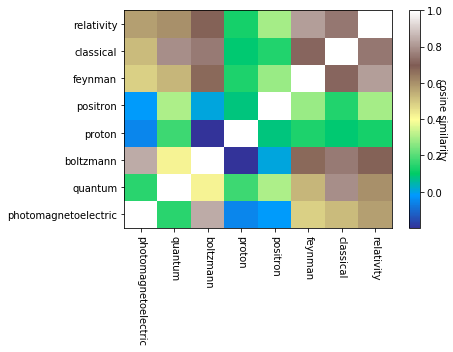

In [68]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrix, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrix.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(keywords, minor=False)

Now let's look at a heatmap of similarities between the first ten documents in the corpus:

In [69]:
targetDocs = apsDF['doi'][:10]

heatmapMatrixD = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixD.append(column)
heatmapMatrixD = np.array(heatmapMatrixD)

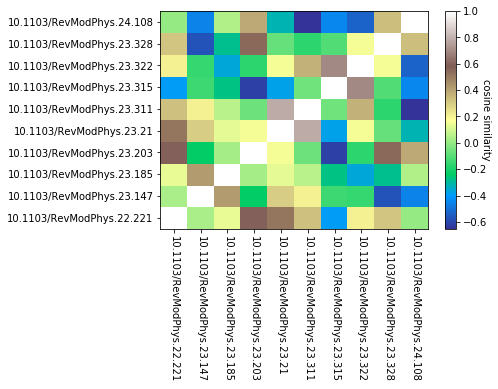

In [70]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixD.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

Now let's look at a heatmap of similarities between the first ten documents and our keywords:

In [71]:
heatmapMatrixC = []

for tagOuter in targetDocs:
    column = []
    tagVec = apsD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, apsD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    heatmapMatrixC.append(column)
heatmapMatrixC = np.array(heatmapMatrixC)

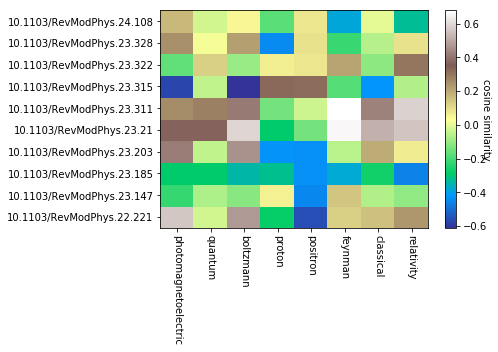

In [72]:
fig, ax = plt.subplots()
hmap = ax.pcolor(heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(hmap)

cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(heatmapMatrixC.shape[0]) + 0.5, minor=False)

a = ax.set_xticklabels(keywords, minor=False, rotation=270)
a = ax.set_yticklabels(targetDocs, minor=False)

We will save the model in case we would like to use it again.

In [73]:
apsD2V.save('apsW2V')

We can later load it:

In [ ]:
#apsD2V = gensim.models.word2vec.Word2Vec.load('data/apsW2V')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that build a doc2vec model with your corpus. Interrogate document and word relationships in the resulting space. Construct a heatmap that plots the distances between a subset of your documents against each other, and against a set of informative words. Find distances between *every* document in your corpus and a word or query of interest. What do these doc-doc proximities reveal about your corpus? What do these word-doc proximities highlight? Demonstrate and document one reasonable way to select a defensible subset of query-relevant documents for subsequent analysis.

In [13]:
# Tokenize the texts and normalize
df['tokenized_words'] = df['text'].apply(lambda x: nltk.word_tokenize(x))
df['normalized_words'] = df['tokenized_words'].apply(lambda x: lucem_illud.normalizeTokens(x, stopwordLst = lucem_illud.stop_words_basic, stemmer = None))

In [14]:
# Train the D2V model
music_keywords = ['classical', 'electronic', 'folk', 'popular', 'progressive', 'psychedelic']
music_taggedDocs = []
for index, row in df.iterrows():
    #Just doing a simple keyword assignment
    docKeywords = [s for s in music_keywords if s in row['normalized_words']]
    docKeywords.append(row['music_type'])
    music_taggedDocs.append(gensim.models.doc2vec.LabeledSentence(words = row['normalized_words'], tags = docKeywords))
df['TaggedAbstracts'] = music_taggedDocs

In [15]:
# Limiting to 100 dimensions
musicD2V = gensim.models.doc2vec.Doc2Vec(df['TaggedAbstracts'], size = 100)
musicD2V.docvecs[5]


array([ 0.20335624, -0.1459503 ,  0.3178204 , -0.00100358, -0.10090392,
       -0.0875242 , -0.03231061, -0.3334406 ,  0.26719365,  0.0910157 ,
        0.02601011,  0.21543954, -0.29994932, -0.1029064 ,  0.18692227,
       -0.0341517 ,  0.12240645,  0.14901873,  0.491185  ,  0.4224885 ,
       -0.186389  ,  0.1185823 ,  0.1891422 , -0.04150023,  0.01935813,
        0.11885298, -0.0642178 ,  0.14097777, -0.06661016,  0.12591125,
        0.36023703,  0.041276  ,  0.19688119,  0.22887902, -0.14891545,
        0.28078154, -0.00627875, -0.1316063 ,  0.11949977,  0.0251457 ,
        0.23753975,  0.1700651 , -0.06937448, -0.07003184,  0.20005196,
       -0.15129954,  0.05261783,  0.06859084,  0.07433812,  0.05988532,
       -0.26004574,  0.00136903, -0.24409254, -0.03485612, -0.22664787,
       -0.00568789, -0.01879136,  0.35243624, -0.01508708,  0.04716942,
        0.12160574,  0.4124517 , -0.02928812,  0.1102508 ,  0.01345864,
        0.07432026, -0.01604598,  0.25889125, -0.11146706,  0.08

In [19]:
# Relationship
musicD2V.most_similar(positive = ['blues', 'drum'], negative = ['saxophone'], topn = 1)


[('soul', 0.8583250045776367)]

<span style="color:blue"> The above result reveals that blues to saxophone is most similar to soul to drum.</span>

In [107]:
musicD2V.most_similar(positive = ['rock', 'drum'], negative = ['blues'], topn = 1)


[('moombahton', 0.8168611526489258)]

<span style="color:blue"> The above result reveals that rock to blues is as moombahton to drum. Moombahton is a music genra that is somewhat similar to house music, and house music is a type of electronic music (not necessarily use drum). So I guess the result means rock is very dissimiar from blues.</span>

In [111]:
musicD2V.docvecs.most_similar([musicD2V['crime'] ], topn=5 )


[('Christian hip hop', 0.9631466269493103),
 ('Drill music', 0.9542875289916992),
 ('Chowtal', 0.9424235224723816),
 ('Ska punk music', 0.9375123381614685),
 ('Cante jondo', 0.9341351985931396)]

<span style="color:blue"> When I search the word 'crime', the most relevant documents are the ones above. Since the names of the documents are the name of corresponding music genras, they are also music genras most relevant to 'crime'. Although I don't know much about the other genras, hip hop music, drill music, and punk music could be very relevant to crime. The result makes sense.

In [23]:
musicD2V.docvecs.most_similar([musicD2V['party'] ], topn=5 )


[('Urban Cowboy music', 0.8884304761886597),
 ('Anti-folk', 0.886398196220398),
 ('Protopunk', 0.8862113952636719),
 ('Red Dirt (music)', 0.8855546712875366),
 ('Ska punk music', 0.8796006441116333)]

<span style="color:blue"> For the word 'party', the most relevant music genras are shown as above. These genras might be frequently played at parties, or their audiences have party very often.</span>

In [115]:
### Heatmap between key words
## Data to plot
WWheatmapMatrix = []
for tagOuter in music_keywords:
    column = []
    tagVec = musicD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in music_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, musicD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    WWheatmapMatrix.append(column)
WWheatmapMatrix = np.array(WWheatmapMatrix)

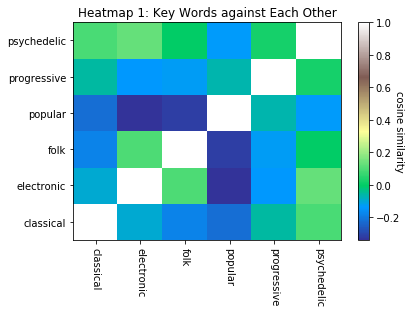

In [117]:
## Plot
fig, ax = plt.subplots()
music_hmap = ax.pcolor(WWheatmapMatrix, cmap='terrain')
cbar = plt.colorbar(music_hmap)
# lable and axis
cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(WWheatmapMatrix.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(WWheatmapMatrix.shape[0]) + 0.5, minor=False)
a = ax.set_xticklabels(music_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(music_keywords, minor=False)
plt.title('Heatmap 1: Key Words against Each Other')
plt.show()


<span style="color:blue"> According to the heatmap above, the adjectives for styles are very distinct. So they could be good words to classify music genras.</span>

In [118]:
### A subset of documents against each other
## Data to plot
music_targetDocs = df['music_type'][:10]
music_heatmapMatrixD = []
for tagOuter in music_targetDocs:
    column = []
    tagVec = musicD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in music_targetDocs:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, musicD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    music_heatmapMatrixD.append(column)
music_heatmapMatrixD = np.array(music_heatmapMatrixD)

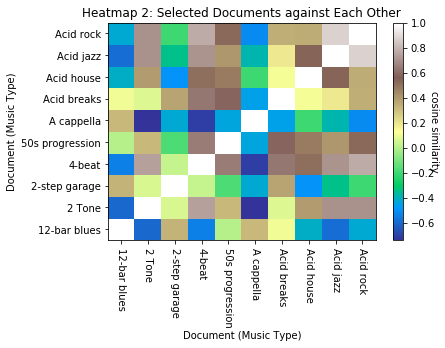

In [125]:
## Plot
fig, ax = plt.subplots()
music_hmap1 = ax.pcolor(music_heatmapMatrixD, cmap='terrain')
cbar = plt.colorbar(music_hmap1)
# lables and axis
cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(music_heatmapMatrixD.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(music_heatmapMatrixD.shape[0]) + 0.5, minor=False)
a = ax.set_xticklabels(music_targetDocs, minor=False, rotation=270)
a = ax.set_yticklabels(music_targetDocs, minor=False)
plt.title('Heatmap 2: Selected Documents against Each Other')
plt.xlabel('Document (Music Type)')
plt.ylabel('Document (Music Type)')
plt.show()


<span style="color:blue"> The heatmap shows the relationships among the selected 10 documents. Since each document represents one music genra, they could be seen as relationships among corresponding music genras. These music genras are very close to each other: acid rock, 2 tone, 4-beat, and acid jazz. Acid house is relatively close to 4-beat and 50 s progression. And the 12-bar blues is not very similar to any other music genras within the selected 10.</span>

In [122]:
### A subset of documents and key words against each other
## Data to plot
music_heatmapMatrixC = []
for tagOuter in music_targetDocs:
    column = []
    tagVec = musicD2V.docvecs[tagOuter].reshape(1, -1)
    for tagInner in music_keywords:
        column.append(sklearn.metrics.pairwise.cosine_similarity(tagVec, musicD2V.docvecs[tagInner].reshape(1, -1))[0][0])
    music_heatmapMatrixC.append(column)
music_heatmapMatrixC = np.array(music_heatmapMatrixC)

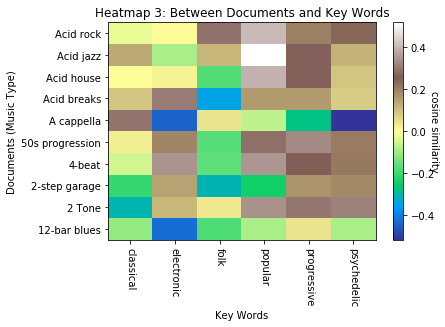

In [124]:
## Plot
fig, ax = plt.subplots()
music_hmap2 = ax.pcolor(music_heatmapMatrixC, cmap='terrain')
cbar = plt.colorbar(music_hmap2)
# lables and axis
cbar.set_label('cosine similarity', rotation=270)
a = ax.set_xticks(np.arange(music_heatmapMatrixC.shape[1]) + 0.5, minor=False)
a = ax.set_yticks(np.arange(music_heatmapMatrixC.shape[0]) + 0.5, minor=False)
a = ax.set_xticklabels(music_keywords, minor=False, rotation=270)
a = ax.set_yticklabels(music_targetDocs, minor=False)
plt.title('Heatmap 3: Between Documents and Key Words')
plt.xlabel('Key Words')
plt.ylabel('Documents (Music Type)')
plt.show()


<span style="color:blue"> The heatmap above shows the relationships between the selected documents and key words. According to the heatmap, acid rock and acid house is very relevant to the word 'popular'. 50s progression is similar to the word 'progressive'. 4-beat is similar to 'electronic' and 'popular'. And the 12-bar blues is similar to the word 'popular'. This means the words could be used describe the description of the corresponding music genras, so the corresponding music genras. For the other pairs, they are not very relevant with cosine similarity. So the selected key words might not be good words to describe the selected music genras, we need to find other words to conclude the styles of the left music genras.</span>

In [45]:
### Find distances between every document in your corpus and a word or query of interest
# Document most like the query
musicD2V.docvecs.most_similar([ musicD2V['crime']+musicD2V['alcohol']+musicD2V['marijuana']], topn=5 )

[('Pornogrind', 0.9625927209854126),
 ('Deathgrind', 0.9495742321014404),
 ('Shabad music', 0.948490560054779),
 ('Goregrind', 0.947351336479187),
 ('Crunkcore', 0.9381937384605408)]

<span style="color:blue"> With the model, I have the distances between every document in my corpus and a query of interest: crime, alcohol, and marijuana. According to the results, the most relevnt music genras are: urban cowboy music, drill music, post-hardcore, ska punk music, and Cante jondo. This means these music genras might be very relevant to the transgressive elements. It suggests that people playing or loving these types of music might have higher possibility to commit or get involved with the transgressive things. If we want to predit the occurrance of the transgressive factors.</span>

In [127]:
musicD2V.docvecs.most_similar([ musicD2V['guitar']+musicD2V['piano']], topn=5 )


[('Slack-key guitar music (kihoalu)', 0.8648005127906799),
 ('Piano blues', 0.7932206392288208),
 ('Son montuno music', 0.7412421107292175),
 ('Igbo', 0.7396787405014038),
 ('50s progression', 0.7238230109214783)]

<span style="color:blue"> As I change the query, the model gives me different results. They mean that the slack-key gitar music (kihoalu), piano blues, son montuno music, Igbo, and 50s progression might use guitar and piano very often. So when we are hearing sounds of guitar and piano appear in one song, the song is most likely to belong to the five music genras.


In [64]:
peace_soft_harmony = musicD2V.docvecs.most_similar([ musicD2V['peace']+musicD2V['soft']+musicD2V['harmony']], topn=100 )
crime_alcohol_drug = musicD2V.docvecs.most_similar([ musicD2V['crime']+musicD2V['alcohol']+musicD2V['drug']], topn=100 )

<span style="color:blue"> Since I could use queries to look for documents most similar to them, I could use this technique to get different subsets with different music styles, at least different descriptive styles. So I get two lists of document names. The first list 'peace_soft_harmony' is constructed using query with 'peace', 'soft', and 'harmony'. The second list is constructed with words of the opposite side: 'crime', 'alcohol', and 'drug'. With these two lists, I could first get the subsets of data, then train different models..</span>

In [65]:
# Get the list of file names in the peace_soft_harmony list
peace_lst = []
for item in peace_soft_harmony:
    peace_lst.append(item[0])

# Get the list of file names in hte crime_alcohol_drug list
danger_lst = []
for item in crime_alcohol_drug:
    danger_lst.append(item[0])

In [66]:
# Creat empty lists to hold the indices of df
peace_indices = []
danger_indices = []

# Get the indices
for i in range(df.shape[0]):
    if df['music_type'].iloc[i] in peace_lst:
        peace_indices.append(i)
    if df['music_type'].iloc[i] in danger_lst:
        danger_indices.append(i)

# Get different subsets of the dataframe
peace_df = df.iloc[peace_indices]
danger_df = df.iloc[danger_indices]

<span style="color:blue"> Since the lists of music genras are decided with different queries, it is resonable to believe that they are valid and different subsets of my corpus.</span>

# Projection

We can also project word vectors to an arbitray semantic dimension. To demonstrate this possibility, let's first load a model trained with New York Times news articles. 

In [25]:
nytimes_model = gensim.models.KeyedVectors.load_word2vec_format('../data/nytimes_cbow.reduced.txt')

First we can visualize with dimension reduction

In [26]:
#words to create dimensions
tnytTargetWords = ['man','him','he', 'woman', 'her', 'she', 'black','blacks','African', 'white', 'whites', 'Caucasian', 'rich', 'richer', 'richest', 'expensive', 'wealthy', 'poor', 'poorer', 'poorest', 'cheap', 'inexpensive']
#words we will be mapping
tnytTargetWords += ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse", "steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry", "basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]


wordsSubMatrix = []
for word in tnytTargetWords:
    wordsSubMatrix.append(nytimes_model[word])
wordsSubMatrix = np.array(wordsSubMatrix)
wordsSubMatrix

array([[-0.343139, -0.117117, -0.50773 , ..., -0.995696,  0.921299,
         0.943769],
       [-0.362909, -0.263528,  0.032661, ..., -0.043032, -0.178965,
         0.353556],
       [-0.70167 , -0.344525, -0.320714, ...,  0.009001,  0.11055 ,
         0.751077],
       ...,
       [-2.391626, -1.90143 ,  1.031182, ...,  2.947464,  1.01588 ,
         2.00033 ],
       [-2.432387, -1.161415,  1.060064, ...,  4.402381,  0.500471,
         1.644596],
       [ 0.981931,  0.628094, -0.747547, ...,  1.612927,  1.148063,
         1.063776]], dtype=float32)

In [28]:
pcaWordsNYT = sklearn.decomposition.PCA(n_components = 50).fit(wordsSubMatrix)
reducedPCA_dataNYT = pcaWordsNYT.transform(wordsSubMatrix)
#T-SNE is theoretically better, but you should experiment
tsneWordsNYT = sklearn.manifold.TSNE(n_components = 2).fit_transform(reducedPCA_dataNYT)


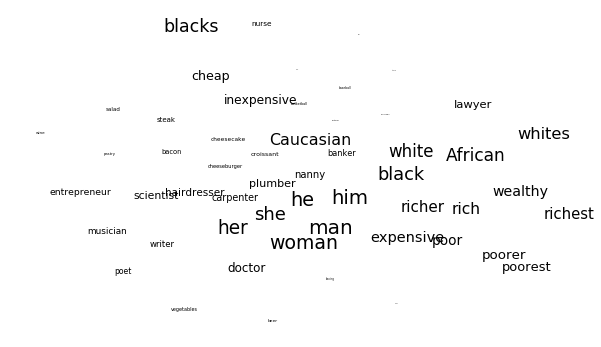

In [29]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(tsneWordsNYT[:, 0], tsneWordsNYT[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(tnytTargetWords):
    ax.annotate(word, (tsneWordsNYT[:, 0][i],tsneWordsNYT[:, 1][i]), size =  20 * (len(tnytTargetWords) - i) / len(tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.show()

Define some convenient functions for getting dimensions. 

In [30]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Let's calculate three dimensions: gender, race, and class.

In [31]:
Gender = dimension(nytimes_model, ['man','him','he'], ['woman', 'her', 'she'])
Race = dimension(nytimes_model, ['black','blacks','African'], ['white', 'whites', 'Caucasian'])
Class = dimension(nytimes_model, ['rich', 'richer', 'richest', 'expensive', 'wealthy'], ['poor', 'poorer', 'poorest', 'cheap', 'inexpensive'])

Here we have some words.

In [32]:
Occupations = ["doctor","lawyer","plumber","scientist","hairdresser", "nanny","carpenter","entrepreneur","musician","writer", "banker","poet","nurse"]

Foods = ["steak", "bacon", "croissant", "cheesecake", "salad", "cheeseburger", "vegetables", "beer", "wine", "pastry"]

Sports  = ["basketball", "baseball", "boxing", "softball", "volleyball", "tennis", "golf", "hockey", "soccer"]

Define a function to project words in a word list to each of the three dimensions.

In [33]:
def makeDF(model, word_list):
    g = []
    r = []
    c = []
    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Gender.reshape(1,-1))[0][0])
        r.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Race.reshape(1,-1))[0][0])
        c.append(sklearn.metrics.pairwise.cosine_similarity(nytimes_model[word].reshape(1,-1), Class.reshape(1,-1))[0][0])
    df = pandas.DataFrame({'gender': g, 'race': r, 'class': c}, index = word_list)
    return df

Get the projections.

In [34]:
OCCdf = makeDF(nytimes_model, Occupations) 
Fooddf = makeDF(nytimes_model, Foods)
Sportsdf = makeDF(nytimes_model, Sports)


Define some useful functions for plotting.

In [35]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    

Plot the occupational words in each of the three dimensions.

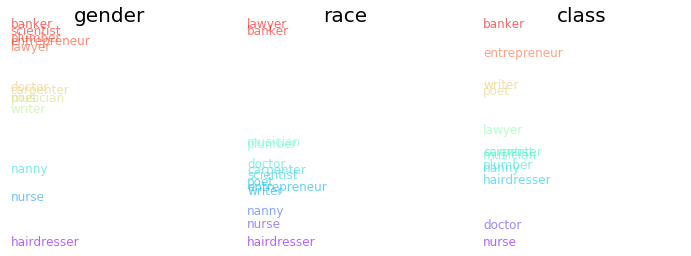

In [36]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, OCCdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, OCCdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, OCCdf, 'class')
plt.show()


Foods:

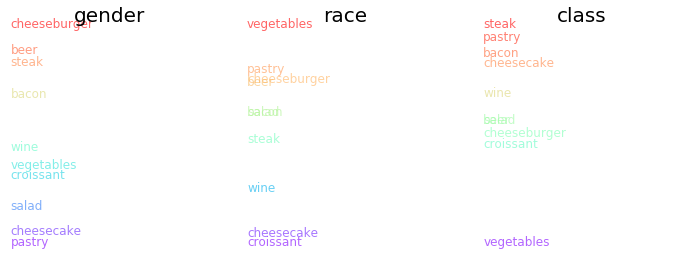

In [37]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Fooddf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Fooddf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Fooddf, 'class')
plt.show()

Sports:

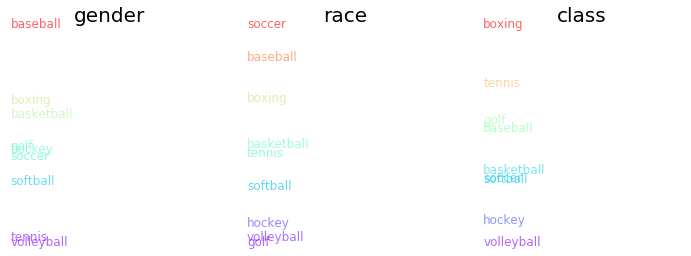

In [38]:
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, Sportsdf, 'gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, Sportsdf, 'race')
ax3 = fig.add_subplot(133)
PlotDimension(ax3, Sportsdf, 'class')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that identify semantic dimensions of interest from your data (e.g., gender: man-woman) and project words onto these dimensions. Plot the array of relevant words along each semantic dimension. Which words are most different. Which dimensions are most different? On which dimension are your words most different? Print three short textual examples from the corpus that illustrate the association you have explored.

<span style="color:red">***Stretch***: Project documents from your corpus along a dimension of interest. Sample relevant documents from your corpus with this functionality and explain your rationale? Calculate the cosine of the angle between two dimensions (encoded as vectors) of interest. What does this suggest about the relationship between them within your corpus? 

<span style="color:red">***Stretch***: Create 90% bootstrap confidence intervals around your word projections onto a given dimension. Which words are *significantly* different on your semantic dimension of interest?

<span style="color:blue"> First, I want to look at relevant words of the whole corpus. After getting the first impression, explore the pattems in different semantic dimensions.</span>

In [146]:
## Identify semantic dimensions of interest
# Words to create dimensions
music_tnytTargetWords = ['crime', 'alcohol', 'drug', 'drugs', 'safe', 'safety', 'peace', 'peaceful', 'graceful', 'elegance', 'elegant', 'expensive', 'cheap', 'rich', 'poor', 'quiet', 'noise', 'noisy', 'suicide', 'depressed', 'technology']
# Words we will be mapping
music_tnytTargetWords += music_keywords
music_tnytTargetWords += ['piano', 'guitar', 'violin', 'orchestra', 'drum']


In [147]:
## Project words onto these dimensions
# Get the submatrix
music_wordsSubMatrix = []
for word in music_tnytTargetWords:
    music_wordsSubMatrix.append(musicD2V[word])
music_wordsSubMatrix = np.array(music_wordsSubMatrix)
music_wordsSubMatrix
# PCA
music_pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(music_wordsSubMatrix)
music_reducedPCA_data = music_pcaWords.transform(music_wordsSubMatrix)
# T-SNE
music_tsneWords = sklearn.manifold.TSNE(n_components = 2).fit_transform(music_reducedPCA_data)


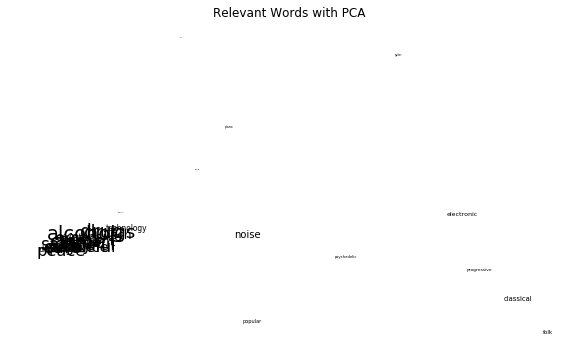

In [148]:
## Plot
# Plot for PCA
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(music_reducedPCA_data[:, 0], music_reducedPCA_data[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(music_tnytTargetWords):
    ax.annotate(word, (music_reducedPCA_data[:, 0][i],music_reducedPCA_data[:, 1][i]), size =  20 * (len(music_tnytTargetWords) - i) / len(music_tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.title('Figure: Relevant Words with PCA')
plt.show()

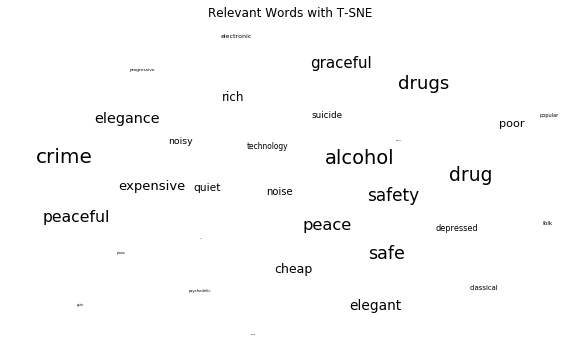

In [149]:
# Plot for T-SNE
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(music_tsneWords[:, 0], music_tsneWords[:, 1], alpha = 0) #Making the points invisible
for i, word in enumerate(music_tnytTargetWords):
    ax.annotate(word, (music_tsneWords[:, 0][i],music_tsneWords[:, 1][i]), size =  20 * (len(music_tnytTargetWords) - i) / len(music_tnytTargetWords))
plt.xticks(())
plt.yticks(())
plt.title('Figure: Relevant Words with T-SNE')
plt.show()

<span style="color:blue"> According to the plots above, the T-SNE performs better than PCA, since the plot with T-SNE gives clearer patterns. In the following part, I would explore my 2 subsets generated at the end of Exercise 2.</span>

In [67]:
## Initialization with two subsets

# Get the list of file names in the peace_soft_harmony list
peace_lst = []
for item in peace_soft_harmony:
    peace_lst.append(item[0])
# Get the list of file names in hte crime_alcohol_drug list
danger_lst = []
for item in crime_alcohol_drug:
    danger_lst.append(item[0])

# Creat empty lists to hold the indices of df
peace_indices = []
danger_indices = []

# Get the indices
for i in range(df.shape[0]):
    if df['music_type'].iloc[i] in peace_lst:
        peace_indices.append(i)
    if df['music_type'].iloc[i] in danger_lst:
        danger_indices.append(i)
# Get the DataFrames
peace_df = df.iloc[peace_indices]
danger_df = df.iloc[danger_indices]

In [74]:
# Get list of common words shared by the two subsets
common_words = []
for item in top_peace_words:
    if item in top_danger_words:
        common_words.append(item)

In [75]:
common_words

['music',
 'also',
 'metal',
 'genre',
 'often',
 'style',
 'bands',
 'rock',
 'sound',
 'house',
 'used',
 'form',
 'early',
 'dance',
 'use',
 'like',
 'pop',
 'one',
 'term',
 'artists',
 'songs',
 'bass',
 'band',
 'known',
 'first',
 'include',
 'instruments',
 'drum',
 'many',
 'electronic',
 'usually',
 'influenced',
 'song',
 'two',
 'played',
 'musical',
 'beats',
 'well',
 'vocals',
 'common',
 'traditional',
 'elements',
 'may',
 'guitar',
 'sometimes',
 'album',
 'late',
 'lyrics',
 'groups',
 'punk',
 'needed',
 'scene',
 'group',
 'called',
 'genres',
 'hardcore',
 'new',
 'black',
 'century',
 'citation',
 'sounds',
 'described',
 'styles',
 'much',
 'musicians',
 'typically',
 'time',
 'name',
 'would',
 'garage',
 'however',
 'part',
 'though',
 'rhythmic',
 'techno',
 'movement',
 'later',
 'word',
 'emerged',
 'forms',
 'drums',
 'heavy',
 'dhrupad',
 'classical',
 'even',
 'developed',
 'subgenre',
 'including',
 'uses',
 'singer',
 'american',
 'influence',
 'work'

In [90]:
# Get dimensions and words to test by looking at the common words
# Dimensions
role_positive = ['artists', 'band']
role_negative = ['audience']
style_positive = ['new', 'modern']
style_negative = ['traditional', 'classical']
# Words
genras = ['metal', 'house', 'rock', 'electronic', 'folk', 'punk', 'industrial', 'pop']
instruments = ['dance', 'song', 'songs', 'sound', 'bass', 'techno', 'singer', 'guitar', 'sounds']
elements = ['rhythm', 'beats', 'lyrics', 'album', 'garage', 'rhythmic', 'melodies', 'vocals', 'rhythms', 'scene', 'cultural']

# Get key words to check
subsets_key_words = role_positive + role_negative + style_positive + style_negative + genras + instruments + elements


In [77]:
## Train W2V models
peaceW2V = gensim.models.word2vec.Word2Vec(peace_df['normalized_sents'].sum())
dangerW2V = gensim.models.word2vec.Word2Vec(danger_df['normalized_sents'].sum())


In [79]:
## Plot for peace_df
# Get the matrix
peace_numWords = 200
top_peace_words = peaceW2V.wv.index2word[:peace_numWords]
peaceSubMatrix = []
for word in top_peace_words:
    peaceSubMatrix.append(peaceW2V[word])
peaceSubMatrix = np.array(peaceSubMatrix)
# PCA
peace_pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(peaceSubMatrix)
peace_reducedPCA_data = peace_pcaWords.transform(peaceSubMatrix)
#T-SNE is theoretically better, but lets try both
peace_tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(peace_reducedPCA_data)

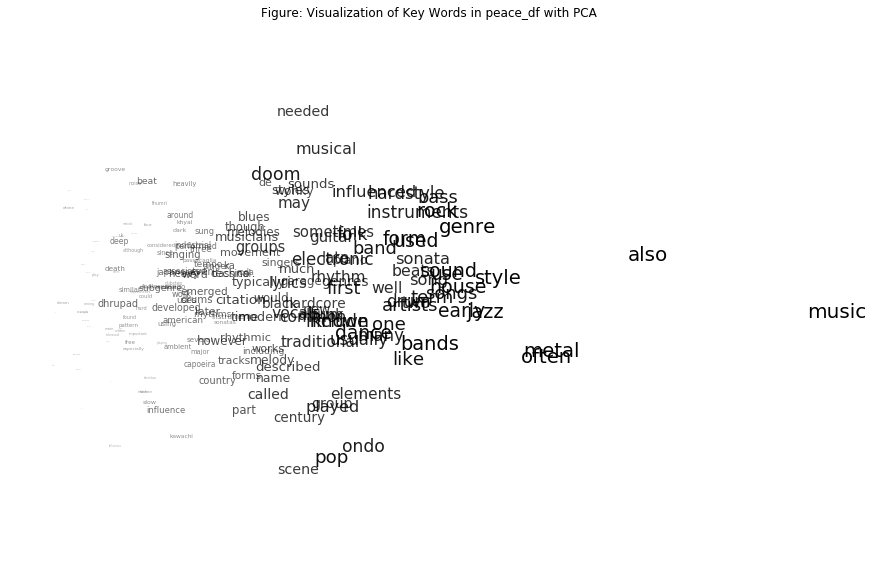

In [80]:
# Plot for PCA
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(peace_reducedPCA_data[:, 0], peace_reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(top_peace_words):
    ax.annotate(word, 
                (peace_reducedPCA_data[:, 0][i],peace_reducedPCA_data[:, 1][i]), 
                size =  20 * (peace_numWords - i) / peace_numWords, 
                alpha = .8 * (peace_numWords - i) / peace_numWords + .2)
plt.xticks(())
plt.yticks(())
plt.title('Figure: Visualization of Key Words in peace_df with PCA')
plt.show()

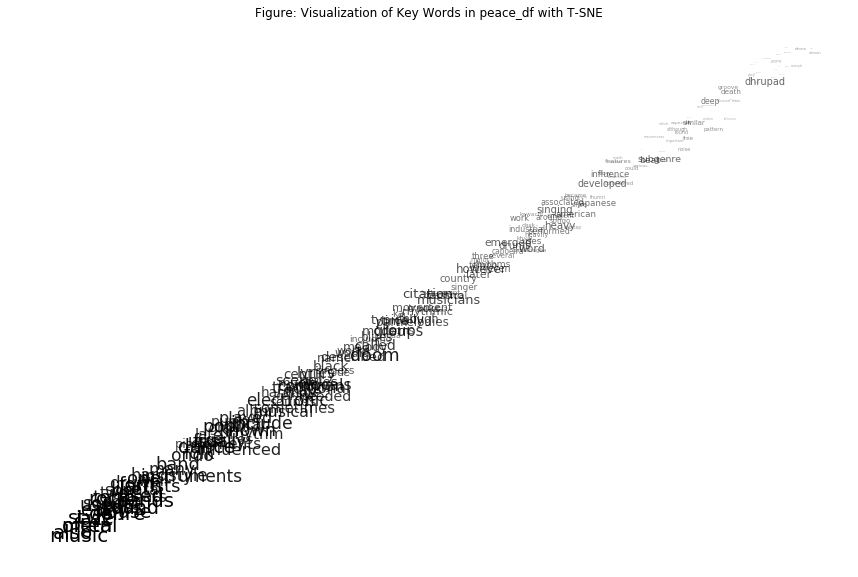

In [81]:
# Plot for T-SNE
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(peace_tsneWords[:, 0], peace_tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(top_peace_words):
    ax.annotate(word, 
                (peace_tsneWords[:, 0][i],peace_tsneWords[:, 1][i]), 
                size =  20 * (peace_numWords - i) / peace_numWords, 
                alpha = .8 * (peace_numWords - i) / peace_numWords + .2)
plt.xticks(())
plt.yticks(())
plt.title('Figure: Visualization of Key Words in peace_df with T-SNE')
plt.show()

In [82]:
## Plot for dangerous music

# Get the matrix
danger_numWords = 200
top_danger_words = dangerW2V.wv.index2word[:danger_numWords]
dangerSubMatrix = []
for word in top_danger_words:
    dangerSubMatrix.append(dangerW2V[word])
dangerSubMatrix = np.array(dangerSubMatrix)
# PCA
danger_pcaWords = sklearn.decomposition.PCA(n_components = 50).fit(dangerSubMatrix)
danger_reducedPCA_data = danger_pcaWords.transform(dangerSubMatrix)
#T-SNE is theoretically better, but let's try both
danger_tsneWords = sklearn.manifold.TSNE(n_components = 2, early_exaggeration = 25).fit_transform(danger_reducedPCA_data)


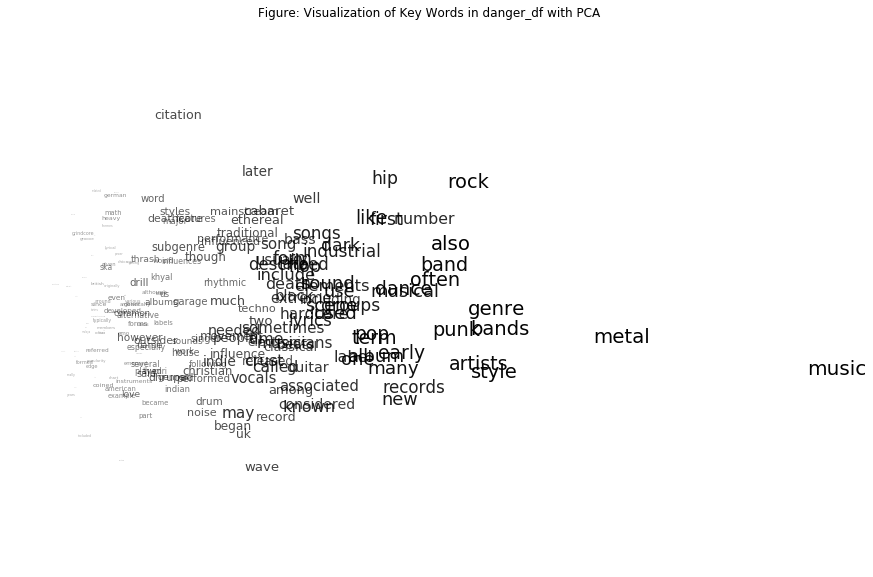

In [83]:
# Plot for PCA
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(danger_reducedPCA_data[:, 0], danger_reducedPCA_data[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(top_danger_words):
    ax.annotate(word, 
                (danger_reducedPCA_data[:, 0][i],danger_reducedPCA_data[:, 1][i]), 
                size =  20 * (danger_numWords - i) / danger_numWords, 
                alpha = .8 * (danger_numWords - i) / danger_numWords + .2)
plt.xticks(())
plt.yticks(())
plt.title('Figure: Visualization of Key Words in danger_df with PCA')
plt.show()

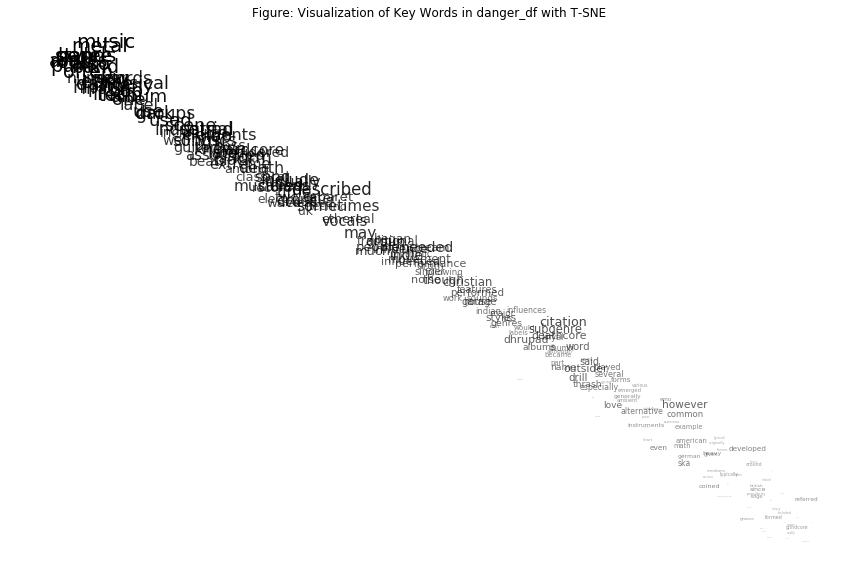

In [84]:
# Plot for T-SNE
fig = plt.figure(figsize = (15,10))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(danger_tsneWords[:, 0], danger_tsneWords[:, 1], alpha = 0)#Making the points invisible 
for i, word in enumerate(top_danger_words):
    ax.annotate(word, 
                (danger_tsneWords[:, 0][i],danger_tsneWords[:, 1][i]), 
                size =  20 * (danger_numWords - i) / danger_numWords, 
                alpha = .8 * (danger_numWords - i) / danger_numWords + .2)
plt.xticks(())
plt.yticks(())
plt.title('Figure: Visualization of Key Words in danger_df with T-SNE')
plt.show()

In [88]:
# To customerize the makeDF function for my analysis, I modify it and save it as a new function
def makeDF_revised(model, word_list, is_peace):
    r = []
    s = []
    for word in word_list:
        if is_peace == 0:
            r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Role_danger.reshape(1,-1))[0][0])
            s.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Style_danger.reshape(1,-1))[0][0])
        else:
            r.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Role_peace.reshape(1,-1))[0][0])
            s.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), Style_peace.reshape(1,-1))[0][0])            
    df = pandas.DataFrame({'role': r, 'style': s}, index = word_list)
    return df

In [87]:
# Construct dimensions

# For peaceful music
Role_peace = dimension(peaceW2V, role_positive, role_negative)
Style_peace = dimension(peaceW2V, style_positive, style_negative)

# For dangerous music
Role_danger = dimension(dangerW2V, role_positive, role_negative)
Style_danger = dimension(dangerW2V, style_positive, style_negative)

In [91]:
# Get projections
# For peaceful music
peace_genras_df = makeDF_revised(peaceW2V, genras, 1) 
peace_instruments_df = makeDF_revised(peaceW2V, instruments, 1)
peace_elements_df = makeDF_revised(peaceW2V, elements, 1)
# For dangerous music
danger_genras_df = makeDF_revised(dangerW2V, genras, 0) 
danger_instruments_df = makeDF_revised(dangerW2V, instruments, 0)
danger_elements_df = makeDF_revised(dangerW2V, elements, 0)

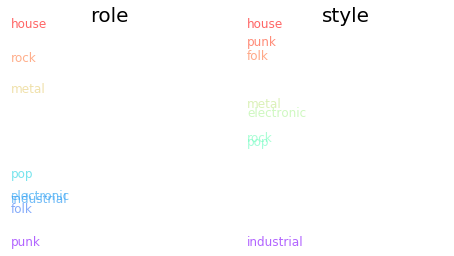

In [96]:
# Plot for peaceful music
# For music genras
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, peace_genras_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, peace_genras_df, 'style')

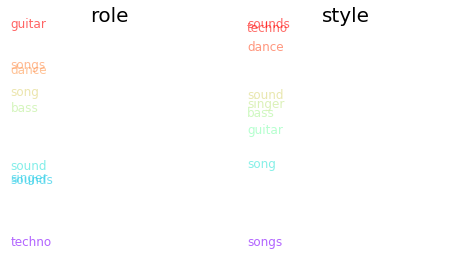

In [93]:
# Plot for peaceful music
# For music instruments
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, peace_instruments_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, peace_instruments_df, 'style')

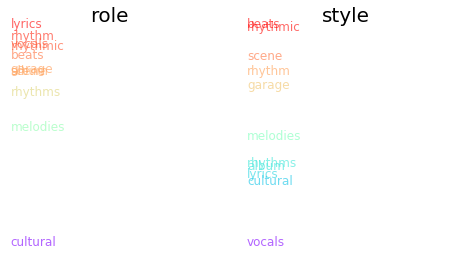

In [97]:
# Plot for peaceful music
# For music elements
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, peace_elements_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, peace_elements_df, 'style')

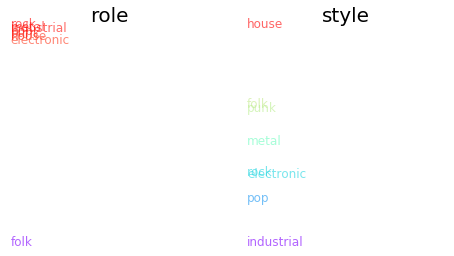

In [98]:
# Plot for dangerous music
# For music genras
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, danger_genras_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, danger_genras_df, 'style')

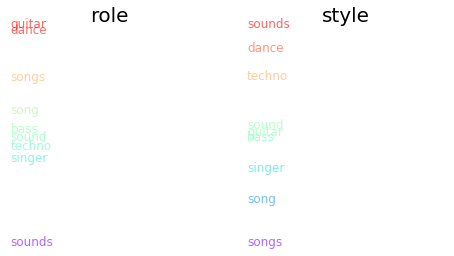

In [99]:
# Plot for dangerous music
# For music instruments
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, danger_instruments_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, danger_instruments_df, 'style')

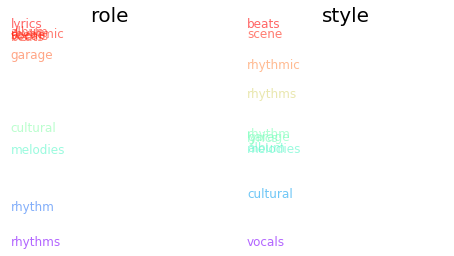

In [100]:
# Plot for dangerous music
# For music elements
fig = plt.figure(figsize = (12,4))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, danger_elements_df, 'role')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, danger_elements_df, 'style')